- **Inference**: [[Inference] Vesuvius Surface 3D Detection](https://www.kaggle.com/code/ipythonx/inference-vesuvius-surface-3d-detection)

In [1]:
from IPython.display import clear_output

# This is required for TPU training at the moment in kaggel env.
# Use the offline wheels that match your weights!
var="/kaggle/input/vsdetection-packages-offline-installer-only/whls"
!pip install \
    "$var"/keras_nightly-3.12.0.dev2025100703-py3-none-any.whl \
    "$var"/tifffile-2025.12.12-py3-none-any.whl \
    "$var"/imagecodecs-2025.11.11-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl \
    "$var"/medicai-0.0.3-py3-none-any.whl \
    --no-index \
    --find-links "$var"
clear_output()

In [2]:
# The `medicai` is medical-based 2D and 3D ML library. 
# We'll use it for segmentaiton model, 3D volume transformation, etc.
!pip install git+https://github.com/innat/medic-ai.git -q

# Installing is optional, we'll be using `npy` format instead of `tif`.
# !pip install imagecodecs tifffile -q


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import os, warnings

os.environ["KERAS_BACKEND"] = "jax"
warnings.filterwarnings('ignore')

In [4]:
import glob
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

# mainly for training API
import keras
from keras import ops
from keras.optimizers.schedules import CosineDecay

# only for tf.data API
import tensorflow as tf

# mainly for 3D or 2D models, transformation, loss, metrics etc
import medicai
from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    Resize,
    RandShiftIntensity,
    RandRotate90,
    RandFlip,
    RandSpatialCrop
)
from medicai.models import (
    UNet, SegFormer, TransUNet, SwinUNETR, UPerNet
)
from medicai.losses import (
    SparseDiceCELoss, SparseTverskyLoss
)
from medicai.metrics import SparseDiceMetric
from medicai.callbacks import SlidingWindowInferenceCallback
from medicai.utils.inference import SlidingWindowInference

In [5]:
# due to distributed training only
keras.config.disable_flash_attention()

# reproducibility
keras.utils.set_random_seed(101)

# distributed config
devices = keras.distribution.list_devices()
data_parallel = keras.distribution.DataParallel(devices=devices)
keras.distribution.set_distribution(data_parallel)
total_device = len(devices)

print(f'detected devices: {devices}')
print(f'total device: {total_device}')

E0000 00:00:1770164531.255214      12 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:238


detected devices: ['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']
total device: 8


In [6]:
keras.version(), keras.config.backend(), medicai.version()

('3.13.0', 'jax', '0.0.3')

## Data Loader

In [7]:
input_shape=(160, 160, 160)
batch_size=1 * total_device
num_classes=3

In [8]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 37.3 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [9]:
from skimage.morphology import skeletonize
from scipy.ndimage import binary_dilation

def generate_tubed_skeleton_numpy(label_vol):
    # label_vol shape: (D, H, W, 1)
    # Extract binary mask for the class of interest (assuming class 1 is ink)
    mask = (label_vol[..., 0] == 1)
    
    # 1. Skeletonize
    skel = skeletonize(mask)
    
    # 2. Tubular Dilation (Tubed Skeleton)
    # Iterations=1 is usually sufficient for "thin" tubes; increase for thicker targets
    tubed_skel = binary_dilation(skel, iterations=1)
    
    # Return as float32 for loss calculation, keeping shape (D, H, W, 1)
    return tubed_skel.astype(np.float32)[..., None]

def add_skeleton_target(image, label):
    # Wrapper to run numpy code inside tf.data graph
    # Inputs: image (D,H,W,1), label (D,H,W,1)
    
    tubed_skel = tf.numpy_function(
        func=generate_tubed_skeleton_numpy,
        inp=[label],
        Tout=tf.float32
    )
    
    # Explicitly set shape because numpy_function loses it
    tubed_skel.set_shape(label.shape)
    
    # Pack both targets into y_true: Channel 0 = Mask, Channel 1 = Skeleton
    # New label shape: (D, H, W, 2)
    combined_label = tf.concat([tf.cast(label, tf.float32), tubed_skel], axis=-1)
    
    return image, combined_label

In [10]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
        "image_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(parsed_example["image"], tf.uint8)
    label = tf.io.decode_raw(parsed_example["label"], tf.uint8)
    image_shape = tf.cast(parsed_example["image_shape"], tf.int64)
    label_shape = tf.cast(parsed_example["label_shape"], tf.int64)
    image = tf.reshape(image, image_shape)
    label = tf.reshape(label, label_shape)
    return image, label

In [11]:
def prepare_inputs(image, label):
    # Add channel dimension
    image = image[..., None] # (D, H, W, 1)
    label = label[..., None] # (D, H, W, 1)

    # Convert to float32
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return image, label

**Preprocessing and Augmentation**

In [12]:
import tensorflow as tf

def random_occlusions_3d_tf(volume,
                            occ_prob=1,
                            max_blocks=6,
                            min_size=2,
                            max_size=8):
    """
    volume: [D, H, W, C] float tensor
    Returns volume with random cuboid occlusions (set to 0) with prob occ_prob.
    """

    def no_aug():
        return volume

    def do_aug():
        v = volume
        shape = tf.shape(v)
        D = shape[0]
        H = shape[1]
        W = shape[2]
        C = shape[3]

        # Start with all-ones occlusion mask [D, H, W, 1]
        occlusion_mask = tf.ones([D, H, W, 1], dtype=v.dtype)

        # Precompute ranges once
        d_range = tf.range(D)
        h_range = tf.range(H)
        w_range = tf.range(W)

        # Loop over blocks in TF graph
        def body(i, mask):
            # random block size
            block_d = tf.random.uniform([], min_size, max_size, dtype=tf.int32)
            block_h = tf.random.uniform([], min_size, max_size, dtype=tf.int32)
            block_w = tf.random.uniform([], min_size, max_size, dtype=tf.int32)

            # random start coords
            d0 = tf.random.uniform([], 0, tf.maximum(D - block_d, 1), dtype=tf.int32)
            h0 = tf.random.uniform([], 0, tf.maximum(H - block_h, 1), dtype=tf.int32)
            w0 = tf.random.uniform([], 0, tf.maximum(W - block_w, 1), dtype=tf.int32)

            d1 = tf.minimum(d0 + block_d, D)
            h1 = tf.minimum(h0 + block_h, H)
            w1 = tf.minimum(w0 + block_w, W)

            # Boolean selection per dimension
            d_sel = tf.logical_and(d_range >= d0, d_range < d1)   # [D]
            h_sel = tf.logical_and(h_range >= h0, h_range < h1)   # [H]
            w_sel = tf.logical_and(w_range >= w0, w_range < w1)   # [W]

            # Broadcast to [D, H, W, 1]
            d_sel = tf.reshape(d_sel, [D, 1, 1, 1])
            h_sel = tf.reshape(h_sel, [1, H, 1, 1])
            w_sel = tf.reshape(w_sel, [1, 1, W, 1])

            block_mask = tf.cast(d_sel & h_sel & w_sel, v.dtype)  # 1 inside block

            # Zero inside the block: mask *= (1 - block_mask)
            new_mask = mask * (1.0 - block_mask)
            return i + 1, new_mask

        def cond(i, mask):
            return i < max_blocks

        _, occlusion_mask = tf.while_loop(
            cond,
            body,
            loop_vars=[tf.constant(0, dtype=tf.int32), occlusion_mask],
            shape_invariants=[
                tf.TensorShape([]),
                tf.TensorShape([None, None, None, 1])
            ]
        )

        # Apply mask to all channels
        v = v * occlusion_mask  # broadcasts over C
        return v

    return tf.cond(
        tf.random.uniform([]) < occ_prob,
        do_aug,
        no_aug
    )


In [13]:
def train_transformation(image, label):
    data = {"image": image, "label": label}
    pipeline = Compose([
        RandSpatialCrop(
            keys=["image", "label"],
            roi_size=input_shape,
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.5),
        RandRotate90(
            keys=["image", "label"], 
            prob=0.4, 
            max_k=3, 
            spatial_axes=(0, 1)
        ),
        RandShiftIntensity(keys=["image"], offsets=0.15, prob=0.5),
        ScaleIntensityRange(
            keys=["image"],
            a_min = 0,
            a_max = 255,
            b_min = 0,
            b_max = 1,
            clip = True,
        ),
    ])
    result = pipeline(data)

    result["image"] = random_occlusions_3d_tf(result["image"])
    return result["image"], result["label"]


def val_transformation(image, label):
    data = {"image": image, "label": label}
    pipeline = Compose([
        ScaleIntensityRange(
            keys=["image"],
            a_min = 0,
            a_max = 255,
            b_min = 0,
            b_max = 1,
            clip = True,
        ),
    ])
    result = pipeline(data)
    return result["image"], result["label"]


In [14]:
def tfrecord_loader(tfrecord_pattern, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(
        tf.io.gfile.glob(tfrecord_pattern)
    )
    dataset = dataset.shuffle(buffer_size=100) if shuffle else dataset 
    dataset = dataset.map(
        parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(
        prepare_inputs,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if shuffle:
        # TRAINING PATH
        dataset = dataset.map(
            train_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # ONLY add skeleton for training
        dataset = dataset.map(
            add_skeleton_target, 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        # VALIDATION PATH
        dataset = dataset.map(
            val_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # Skeleton target skipped here!
        
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [15]:
# Generate the exact list of filenames for 0 to 129
base_path = "/kaggle/input/vesuvius-tfrecords/training_shard_{}.tfrec"
train_files = [base_path.format(i) for i in range(130)]  # Generates 0, 1, ... 129

# Validation file
val_files = [base_path.format(130)]

# Pass the LIST directly (glob handles lists of paths correctly)
train_loader = tfrecord_loader(
    train_files, batch_size=batch_size, shuffle=True
)

val_loader = tfrecord_loader(
    val_files, batch_size=1, shuffle=False
)

In [16]:
x, y = next(iter(train_loader))
x.shape, y.shape

(TensorShape([8, 160, 160, 160, 1]), TensorShape([8, 160, 160, 160, 2]))

**Viz**

In [17]:
def plot_sample(x, y, sample_idx=0, max_slices=16):
    img = np.squeeze(x[sample_idx])  # (D, H, W)
    mask = np.squeeze(y[sample_idx])  # (D, H, W)
    D = img.shape[0]

    # Decide which slices to plot
    step = max(1, D // max_slices)
    slices = range(0, D, step)

    n_slices = len(slices)
    fig, axes = plt.subplots(2, n_slices, figsize=(3*n_slices, 6))

    for i, s in enumerate(slices):
        axes[0, i].imshow(img[s], cmap='gray')
        axes[0, i].set_title(f"Slice {s}")
        axes[0, i].axis('off')

        axes[1, i].imshow(mask[s], cmap='gray')
        axes[1, i].set_title(f"Mask {s}")
        axes[1, i].axis('off')

    plt.suptitle(f"Sample {sample_idx}")
    plt.tight_layout()
    plt.show()


In [18]:
def plot_planes(image, mask, alpha=0.4):
    # Central slices
    d, h, w = image.shape
    axial_img    = image[d // 2]
    coronal_img  = image[:, h // 2, :]
    sagittal_img = image[:, :, w // 2]

    axial_msk    = mask[d // 2]
    coronal_msk  = mask[:, h // 2, :]
    sagittal_msk = mask[:, :, w // 2]

    slices_img = [axial_img, coronal_img, sagittal_img]
    slices_msk = [axial_msk, coronal_msk, sagittal_msk]
    
    titles = ["Axial (XY plane)", "Coronal (XZ plane)", "Sagittal (YZ plane)"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.imshow(slices_img[i], cmap="gray")

        # overlay jet only where mask > 0
        m = slices_msk[i]
        if m.max() > 0:
            ax.imshow(m, cmap="jet", alpha=alpha)

        ax.set_title(titles[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [19]:
x, y = next(iter(val_loader))
x.shape, y.shape 

(TensorShape([1, 320, 320, 320, 1]), TensorShape([1, 320, 320, 320, 1]))

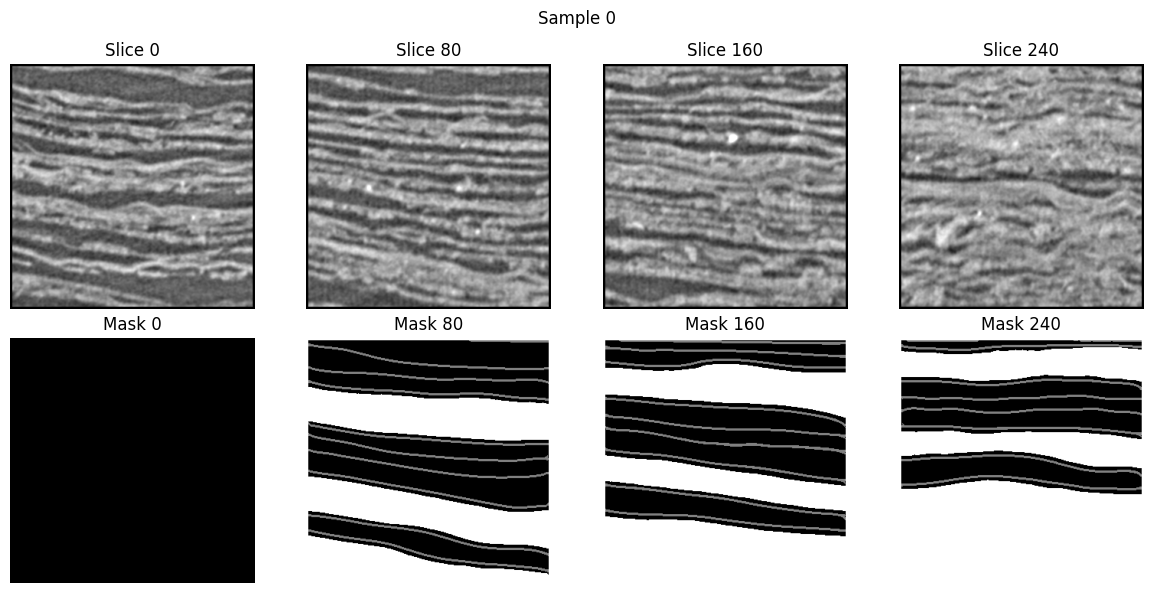

In [20]:
plot_sample(
    x, y[:,:,:,:,0], sample_idx=0, max_slices=4
)

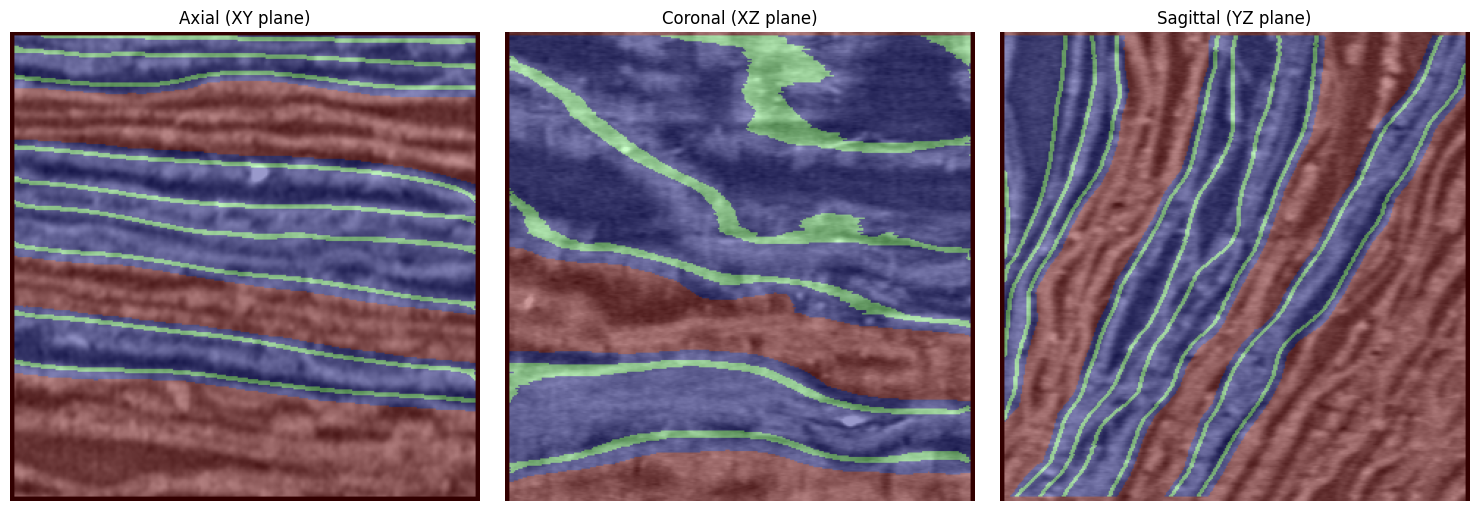

In [21]:
plot_planes(
    np.squeeze(x[0]), # picking one sample
    np.squeeze(y[0,:,:,:,0])  # picking one sample
)

## Model

In [22]:
## check available models (classification + segmentation)
medicai.models.list_models()

                     Model Registry Catalog                      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Segmentor        ┃ Backbone Family ┃ Variants                 ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ • attention_unet │ convnext        │ • convnext_base          │
│ • deeplabv3plus  │                 │ • convnext_large         │
│ • unet           │                 │ • convnext_small         │
│ • unet_plus_plus │                 │ • convnext_tiny          │
│ • upernet        │                 │ • convnext_v2_atto       │
│                  │                 │ • convnext_v2_base       │
│                  │                 │ • convnext_v2_femto      │
│                  │                 │ • convnext_v2_huge       │
│                  │                 │ • convnext_v2_large      │
│                  │                 │ • convnext_v2_nano       │
│                  │                 │ • convnext_v2_pico       │
│                  │                 │ • convnext_v2_small      │
│                  │                 │ • convnext_v2_tiny       │
│                  │                 │ • convnext_xlarge        │
├──────────────────┼─────────────────┼──────────────────────────┤
│ • attention_unet │ densenet        │ • densenet121            │
│ • deeplabv3plus  │                 │ • densenet169            │
│ • trans_unet     │                 │ • densenet201            │
│ • unet           │                 │ • densenet264            │
│ • unet_plus_plus │                 │                          │
│ • upernet        │                 │                          │
├──────────────────┼─────────────────┼──────────────────────────┤
│ • attention_unet │ efficientnet    │ • efficientnet_b0        │
│ • deeplabv3plus  │                 │ • efficientnet_b1        │
│ • trans_unet     │                 │ • efficientnet_b2        │
│ • unet           │                 │ • efficientnet_b3        │
│ • unet_plus_plus │                 │ • efficientnet_b4        │
│ • upernet        │                 │ • efficientnet_b5        │
│                  │                 │ • efficientnet_b6        │
│                  │                 │ • efficientnet_b7        │
│                  │                 │ • efficientnet_b8        │
│                  │                 │ • efficientnet_l2        │
│                  │                 │ • efficientnet_v2_b0     │
│                  │                 │ • efficientnet_v2_b1     │
│                  │                 │ • efficientnet_v2_b2     │
│                  │                 │ • efficientnet_v2_b3     │
│                  │                 │ • efficientnet_v2_l      │
│                  │                 │ • efficientnet_v2_m      │
│                  │                 │ • efficientnet_v2_s      │
├──────────────────┼─────────────────┼──────────────────────────┤
│ • segformer      │ mit             │ • mit_b0                 │
│ • upernet        │                 │ • mit_b1                 │
│                  │                 │ • mit_b2                 │
│                  │                 │ • mit_b3                 │
│                  │                 │ • mit_b4                 │
│                  │                 │ • mit_b5                 │
├──────────────────┼─────────────────┼──────────────────────────┤
│ • attention_unet │ resnet          │ • resnet101              │
│ • deeplabv3plus  │                 │ • resnet101_v2           │
│ • trans_unet     │                 │ • resnet152              │
│ • unet           │                 │ • resnet152_v2           │
│ • unet_plus_plus │                 │ • resnet18               │
│ • upernet        │                 │ • resnet200_vd           │
│                  │                 │ • resnet34               │
│                  │                 │ • resnet50               │
│                  │                 │ • resnet50_v2            │
│                  │                 │ •

<!DOCTYPE html>

In [24]:
model = TransUNet(
        input_shape=(160, 160, 160, 1),
        encoder_name="seresnext50",
        classifier_activation="softmax",
        num_classes=3,
    )

model.load_weights("/kaggle/input/train-vesuvius-surface-3d-detection-on-tpu/model.weights.h5")


In [25]:
# ALERT: This attributes only available in medicai (not in core keras)
model.instance_describe()

Instance of TransUNet
  • input_shape: (160, 160, 160, 1)
  • num_classes: 3
  • num_queries: 100
  • encoder: SEResNeXt50(
    • name: 'SEResNeXt503D'
    • trainable: True
    • input_shape: (160, 160, 160, 1)
    • include_rescaling: False
    )
  • encoder_name: 'seresnext50'
  • encoder_depth: 5
  • classifier_activation: softmax
  • num_vit_layers: 12
  • num_heads: 8
  • embed_dim: 512
  • mlp_dim: 1024
  • dropout_rate: 0.1
  • decoder_activation: leaky_relu
  • decoder_filters: (256, 128, 64, 32, 16)
  • encoder: SEResNeXt50(
    • name: 'SEResNeXt503D'
    • trainable: True
    • input_shape: (160, 160, 160, 1)
    • include_rescaling: False
    )

In [27]:
import keras
from keras import ops
from medicai.losses import SparseDiceCELoss

# --- Monitor for Skeleton Loss ---
class SkeletonLossMonitor(keras.metrics.Metric):
    def __init__(self, name="skel_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_variable(shape=(), initializer="zeros", name="total")
        self.count = self.add_variable(shape=(), initializer="zeros", name="count")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Only calc if we have the skeleton channel (Training data)
        if y_true.shape[-1] == 2:
            y_true_skel = y_true[..., 1]
            pred_prob = y_pred[..., 1]
            
            # Re-calculate the specific term we want to watch
            intersection = keras.ops.sum(pred_prob * y_true_skel, axis=(1, 2, 3))
            skeleton_sum = keras.ops.sum(y_true_skel, axis=(1, 2, 3))
            
            has_skeleton = keras.ops.cast(skeleton_sum > 0, dtype="float32")
            recall = (intersection + 1e-6) / (skeleton_sum + 1e-6)
            
            # We want to see the loss value
            val = (1.0 - recall) * has_skeleton
            
            # Average over batch
            self.total.assign_add(keras.ops.mean(val))
            self.count.assign_add(1.0)

    def result(self):
        return self.total / (self.count + 1e-6)

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

# --- Monitor for Base (Dice) Loss ---
class BaseLossMonitor(keras.metrics.Metric):
    def __init__(self, num_classes, name="base_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_fn = SparseDiceCELoss(from_logits=False, num_classes=num_classes, ignore_class_ids=2)
        self.total = self.add_variable(shape=(), initializer="zeros", name="total")
        self.count = self.add_variable(shape=(), initializer="zeros", name="count")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Handle shape: if 2 channels, take only the first (mask)
        if len(y_true.shape) == 5 and y_true.shape[-1] == 2:
            y_true_mask = y_true[..., 0:1]
        else:
            y_true_mask = y_true 
            
        val = self.base_fn(y_true_mask, y_pred)
        self.total.assign_add(val)
        self.count.assign_add(1.0)

    def result(self):
        return self.total / (self.count + 1e-6)

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

class SkeletonRecallPlusDiceLoss(keras.losses.Loss):
    def __init__(
        self,
        num_classes,
        w_srec=0.5,
        w_fp=0.3,          # <-- NEW
        name="skel_recall_fp_loss",
    ):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.w_srec = w_srec
        self.w_fp = w_fp  # <-- NEW

        self.base_loss_fn = SparseDiceCELoss(
            from_logits=False,
            num_classes=num_classes,
            ignore_class_ids=2,
        )

    def call(self, y_true, y_pred):
        # --------------------
        # GT unpacking
        # --------------------
        y_true_mask = y_true[..., 0]   # 0/1/2 (2 = ignore)
        y_true_skel = y_true[..., 1]

        pred_ink_prob = y_pred[..., 1]

        # Valid (non-ignore) mask
        valid_mask = keras.ops.cast(y_true_mask != 2, "float32")

        # --------------------
        # 1. Base Dice+CE Loss
        # --------------------
        base_loss = self.base_loss_fn(
            y_true_mask[..., None],
            y_pred,
        )

        # --------------------
        # 2. Skeleton Recall Loss
        # --------------------
        intersection = keras.ops.sum(
            pred_ink_prob * y_true_skel * valid_mask,
            axis=(1, 2, 3),
        )
        skeleton_sum = keras.ops.sum(
            y_true_skel * valid_mask,
            axis=(1, 2, 3),
        )

        has_skeleton = keras.ops.cast(skeleton_sum > 0, "float32")
        recall = (intersection + 1e-6) / (skeleton_sum + 1e-6)
        skel_loss = keras.ops.mean((1.0 - recall) * has_skeleton)

        # --------------------
        # 3. FP Volume Loss (NEW)
        # --------------------
        gt_fg = keras.ops.cast(y_true_mask == 1, "float32")
        gt_bg = keras.ops.cast(y_true_mask == 0, "float32")

        fp_volume = (
            pred_ink_prob * gt_bg * valid_mask
        )

        fp_loss = keras.ops.sum(fp_volume) / (
            keras.ops.sum(gt_bg * valid_mask) + 1e-6
        )

        # --------------------
        # Final Loss
        # --------------------
        return (
            base_loss
            + self.w_srec * skel_loss
            + self.w_fp * fp_loss
        )

In [28]:
num_samples = 780
epochs = 100
total_steps = (num_samples // batch_size) * epochs
warmup_steps = (num_samples // batch_size) * 5

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, 
    decay_steps=total_steps, 
    alpha=0.1 # Don't go to 0, stay at 5e-7
)

# define optomizer, loss, metrics
optim = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-5,
)
# older loss fn without skeletal loss
# loss_fn = SparseDiceCELoss(
#     from_logits=False, 
#     num_classes=num_classes,
#     ignore_class_ids=2,
# )
loss_fn = SkeletonRecallPlusDiceLoss(
    num_classes=num_classes,
)

metrics = [
    SparseDiceMetric(
        from_logits=False, 
        num_classes=num_classes, 
        ignore_class_ids=2,
        name='dice'
    ),
]

model.compile(
    optimizer=optim,
    loss=loss_fn,
    metrics=metrics,
)

swi_callback_metric = SparseDiceMetric(
    from_logits=False,
    ignore_class_ids=2,
    num_classes=num_classes,
    name='val_dice',
)

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_loader,
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=10,
    overlap=0.5,
    roi_size=input_shape,
    sw_batch_size=2 * total_device,
    save_path="model.weights.h5"
)
class PeriodicWeightsSaver(keras.callbacks.Callback):
    def __init__(self, interval=25, save_path_template="checkpoint_epoch_{epoch}.weights.h5"):
        super().__init__()
        self.interval = interval
        self.save_path_template = save_path_template

    def on_epoch_end(self, epoch, logs=None):
        # epoch is 0-indexed, so we check (epoch + 1)
        if (epoch + 1) % self.interval == 0:
            save_path = self.save_path_template.format(epoch=epoch + 1)
            self.model.save_weights(save_path)
            print(f"\n[Snapshot] Saved periodic weights to: {save_path}")
snapshot_cb = PeriodicWeightsSaver(
    interval=20, 
    save_path_template="fine_tuning_epoch_{epoch}.weights.h5"
)

In [29]:
import keras
from keras import ops
from medicai.metrics import SparseDiceMetric

class MaskOnlySparseDiceMetric(SparseDiceMetric):
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true comes from train_loader with shape: (B, D, H, W, 2) -> [Mask, Skeleton]
        # We only need Channel 0 (the Mask) for the Dice calculation
        # Check if we have the extra channel dimension
        if len(y_true.shape) == 5 and y_true.shape[-1] == 2:
            y_true_mask = y_true[..., 0]
            # Restore channel dim to match expectations: (B, D, H, W, 1)
            y_true_mask = ops.expand_dims(y_true_mask, axis=-1)
        else:
            y_true_mask = y_true
            
        return super().update_state(y_true_mask, y_pred, sample_weight=sample_weight)

# Re-define metrics using the wrapper to handle the training data format
metrics = [
    MaskOnlySparseDiceMetric(
        from_logits=False, num_classes=num_classes, ignore_class_ids=2, name='dice'
    ),
    SkeletonLossMonitor(name='skel_L'), # Short name to fit in progress bar
    BaseLossMonitor(num_classes=num_classes, name='base_L')
]

# Re-compile the model with the new metric
# Note: optim and loss_fn are preserved from your previous cells
model.compile(
    optimizer=optim,
    loss=loss_fn,
    metrics=metrics
)



In [ ]:
# ALERT: Starting may take time.
model.fit(
    train_loader,
    epochs=epochs,
    callbacks=[
        swi_callback,snapshot_cb
    ]
)

Epoch 1/100


In [ ]:
"""
Vesuvius competition metric.

Expects standard Kaggle paths and Linux in order to manage dependencies.
"""

import glob
import importlib
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageSequence


class ParticipantVisibleError(Exception):
    pass


class HostVisibleError(Exception):
    pass


def load_volume(path):
    im = Image.open(path)
    slices = []
    for i, page in enumerate(ImageSequence.Iterator(im)):
        slice_array = np.array(page)
        slices.append(slice_array)
    volume = np.stack(slices, axis=0)
    return volume


def install_dependencies():
    """On Kaggle, the topometrics library must be installed during the run. This function handles the entire process."""
    try:
        import topometrics.leaderboard

        return None
    # The broad exception is necessary as the initial import can fail for multiple reasons.
    except:
        pass

    resources_dir = '/kaggle/input/vesuvius-metric-resources'
    install_dir = '/kaggle/working/topological-metrics-kaggle'

    try:
        subprocess.run(
            f'cd {resources_dir} && uv pip install --no-index --find-links=wheels -r topological-metrics-kaggle/requirements.txt',
            shell=True,
            check=True,
        )
        subprocess.run(f'cd /kaggle/working && cp -r {resources_dir}/topological-metrics-kaggle .', shell=True, check=True)
        subprocess.run(
            f'cd {install_dir} && chmod +x scripts/setup_submodules.sh scripts/build_betti.sh && make build-betti',
            shell=True,
            check=True,
        )
        subprocess.run(
            f'cd {install_dir} && uv pip install -e . --no-deps --no-index --no-build-isolation -v',
            shell=True,
            check=True,
        )
        # Add the new library to Python's path and invalidate caches to ensure it's found.
        sys.path.append('/kaggle/working/topological-metrics-kaggle/src')
        importlib.invalidate_caches()

    except Exception as err:
        raise HostVisibleError(f'Failed to install topometrics library: {err}')


def generate_standard_submission(submission_dir: str) -> None:
    # Dependencies installed here as generate_standard_submission is the first metric function that gets called by the orchestrator.
    submission_tifs = glob.glob(f'{submission_dir}/**/*.tif', recursive=True)
    if len(submission_tifs) == 0:
        submission_tifs = glob.glob('/kaggle/tmp/**/*.tif', recursive=True)
    if len(submission_tifs) == 0:
        raise ParticipantVisibleError('No submission files found')
    df = pd.DataFrame({'tif_paths': submission_tifs})
    df['id'] = df['tif_paths'].apply(lambda x: x.split('/')[-1].split('.')[0])
    os.chdir('/kaggle/working')
    df[['id', 'tif_paths']].to_csv('submission.csv', index=False)


def score_single_tif(
    gt_path,
    pred_path,
    surface_tolerance,
    voi_connectivity=26,
    voi_transform='one_over_one_plus',
    voi_alpha=0.3,
    topo_weight=0.3,
    surface_dice_weight=0.35,
    voi_weight=0.35,
):
    gt: np.ndarray = load_volume(gt_path)
    pr: np.ndarray = load_volume(pred_path)

    install_dependencies()
    # The import is here to ensure dependencies are loaded first.
    try:
        # Use a standard import now that the path is reliably set.
        import topometrics.leaderboard
    except Exception as err:
        raise HostVisibleError(f'Failed to import topometrics after installation: {err}')

    score_report = topometrics.leaderboard.compute_leaderboard_score(
        predictions=pr,
        labels=gt,
        dims=(0, 1, 2),
        spacing=(1.0, 1.0, 1.0),  # (z, y, x)
        surface_tolerance=surface_tolerance,  # in spacing units
        voi_connectivity=voi_connectivity,
        voi_transform=voi_transform,
        voi_alpha=voi_alpha,
        combine_weights=(topo_weight, surface_dice_weight, voi_weight),  # (Topo, SurfaceDice, VOI)
        fg_threshold=None,  # None => legacy "!= 0"; else uses "x > threshold"
        ignore_label=2,  # voxels with this GT label are ignored
        ignore_mask=None,  # or pass an explicit boolean mask
    )
    return np.clip(score_report.score, a_min=0.0, a_max=1.0)


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    surface_tolerance: float = 2.0,
    voi_connectivity: int = 26,
    voi_transform: str = 'one_over_one_plus',
    voi_alpha: float = 0.3,
    topo_weight: float = 0.3,
    surface_dice_weight: float = 0.35,
    voi_weight: float = 0.35,
) -> float:
    """Returns the mean per-volume Topological Score, Surface Dice, and VOI Scores."""
    if not solution['tif_paths'].apply(os.path.exists).all():
        raise HostVisibleError('Invalid solution file paths')

    solution['pred_paths'] = submission['tif_paths']
    solution['image_score'] = solution.apply(
        lambda row: score_single_tif(
            row['tif_paths'],
            row['pred_paths'],
            surface_tolerance,
            voi_connectivity=voi_connectivity,
            voi_transform=voi_transform,
            voi_alpha=voi_alpha,
            topo_weight=topo_weight,
            surface_dice_weight=surface_dice_weight,
            voi_weight=voi_weight,
        ),
        axis=1,
    )
    return float(np.mean(solution['image_score']))

## Eval

In [ ]:
# model.load_weights(
#     "/kaggle/input/train-vesuvius-surface-3d-detection-on-tpu/fine_tuning_epoch_200.weights.h5"
# )
# swi = SlidingWindowInference(
#     model,
#     num_classes=num_classes,
#     roi_size=input_shape,
#     sw_batch_size=1 * total_device,
#     overlap=0.5,
# )

In [ ]:
# dice = SkeletonRecallPlusDiceLoss(
#     num_classes=num_classes,
# )


In [ ]:
# loss = []

In [ ]:
# i =0
# for sample in val_loader:
#     x, y = sample
#     output = swi(x)
#     y = ops.convert_to_tensor(y)
#     output = ops.convert_to_tensor(output)
#     loss.append(dice.call(y, output))
    
    
    



In [ ]:
# dice_score = np.mean((ops.convert_to_numpy(loss)))
# print(f"Dice Score: {dice_score/6:.4f}")


In [ ]:
# x, y = next(iter(val_loader))
# x.shape, y.shape

In [ ]:
# y_pred = swi(x)
# y_pred.shape

In [ ]:
# segment = y_pred.argmax(-1).astype(np.uint8)
# segment.shape, np.unique(segment)

In [ ]:
# plot_sample(
#     x, segment, sample_idx=0, max_slices=4
# )

**Next Stop**

- [Affinity Feature Strengthening](https://arxiv.org/pdf/2211.06578)
- [Meta-Tubular-Net: A Robust Topology-Aware Re-Weighting Network](file:///C:/Users/ASUS/Pictures/Screenshots/ssrn-4132287.pdf)
- [Landmark-Assisted Anatomy-Sensitive](file:///C:/Users/ASUS/Downloads/diagnostics-13-02260-v2.pdf)
- [LEAD: Self-Supervised Landmark Estimation](https://arxiv.org/pdf/2204.02958)
- [TopoSeg: Topology-Aware](https://openaccess.thecvf.com/content/ICCV2023/papers/He_TopoSeg_Topology-Aware_Nuclear_Instance_Segmentation_ICCV_2023_paper.pdf)
- [Virtually Unrolling the Herculaneum Papyri](https://arxiv.org/pdf/2512.04927v1)